# Recursion Limits

In this notebook let's make some tries defining `remaining_steps` inside a custom `state_schema` and seeing if it works for recursion limit control. 

Then after that try and set explicit control flows. I know how to do it in a `Command[Literal["next_possible_node1", "next_possible_node2"]]` fashion, can I use that? 

> Here are some sources for this topic:
> - [Graph-API: Impose a recursion limit](https://langchain-ai.github.io/langgraph/how-tos/graph-api/?utm_source=chatgpt.com#impose-a-recursion-limit);
> - ['Medium' post about recursion limits](https://medium.com/@pankajchandravanshi/df371792c8b9);
> - [Adding `remaining_steps` fixed a recursion error problem](https://stackoverflow.com/questions/79446089/langgraph-create-react-agent-with-sqltoolkit-issue-sorry-need-more-steps-to-pr?utm_source=chatgpt.com).

### Custom state schema

Let's make a very simple example: a custom state with a counter that we increment by $1$ at every step (basically the step counter).

In [3]:
from typing import Annotated
from langgraph.graph import MessagesState

# reducer
def counter_add(current_value: int, value_to_add: int):
    return current_value + value_to_add

# custom state
class CustomState(MessagesState):
    counter: Annotated[int, counter_add]  
    remaining_steps: int 

Also, let's make another state schema for experiments where we use the `RemainingSteps` marker from `langgraph.managed.is_last_step`. LangGraph should recognize this type and manage it automatically.

In [4]:
from langgraph.managed.is_last_step import RemainingSteps

class RemainingStepsState(MessagesState):
    counter: Annotated[int, counter_add] # = 8 setting defaults here won't work 
    remaining_steps: RemainingSteps # = 5 defaults need to be set in graph's initial state

>**Note:** LangGraph does not support default values defined inside your state class (especially with annotated or reduced fields). Always provide defaults at runtime via an `initial_state` (see below). 
>
> *Don’t assign a default inside the class definition or via annotation—LangGraph will ignore it.*

### Create agent

In [5]:
# helper function for printing

from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [6]:
# tools

from langchain_core.messages import ToolMessage
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from typing_extensions import Annotated
from langgraph.types import Command


@tool
def update_counter(
    state: Annotated[CustomState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """Updates the internal counter, incrementing it by 1"""
    return Command(
        update={
            "counter": 1,
            "messages": [ToolMessage(content="Counter updated", tool_call_id=tool_call_id)]
        }
    )


@tool
def check_counter_value(state: Annotated[CustomState, InjectedState],
                        tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """Checks the value of the counter"""

    counter = state.get("counter")
    remaining_steps = state.get("remaining_steps")

    return Command(
        update={
            "messages" : [ToolMessage(content=f"Counter value: {counter}\nRemaining steps: {remaining_steps}, type:{type(remaining_steps)}", tool_call_id=tool_call_id)]
        }
    )


#### Create two agents with the two custom states for experiments

In [7]:
# agent

from langgraph.prebuilt import create_react_agent

agent = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[update_counter, check_counter_value],
    prompt="You are an helpful AI assistant.",
    name="counter_agent",
    state_schema=CustomState
)

agent_RemainingSteps = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[update_counter, check_counter_value],
    prompt="You are an helpful AI assistant.",
    name="counter_agent",
    state_schema=RemainingStepsState
)


### Experiments with `remaining_steps` 

#### Using `RemainingSteps`:

In [8]:
# run the agent
from langchain_core.messages import HumanMessage

initial_state = {
    "messages": [HumanMessage(content="Update your counter 3 times and then check its value")],
}

for chunk in agent_RemainingSteps.stream(initial_state):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: counter_agent
Tool Calls:
  update_counter (call_zfiQ0YS8az49Lovm89lo19qm)
 Call ID: call_zfiQ0YS8az49Lovm89lo19qm
  Args:
  update_counter (call_H6heq7lX3fgxWNkzMcKGH9Cp)
 Call ID: call_H6heq7lX3fgxWNkzMcKGH9Cp
  Args:
  update_counter (call_fqRzIxz1w1CXuuN0D34zNAKD)
 Call ID: call_fqRzIxz1w1CXuuN0D34zNAKD
  Args:


Update from node tools:


================================= Tool Message =================================
Name: update_counter

Counter updated


Update from node tools:


================================= Tool Message =================================
Name: update_counter

Counter updated


Update from node tools:


================================= Tool Message =================================
Name: update_counter

Counter updated


Update from node agent:


================================== Ai Message ==================================
Name: counter_agent


Without providing defaults in the initial state, LangGraph automatically initializes `remaining_steps` to $25$, since we defined it through `RemainingSteps`. Also the `counter` is initialized to $0$ as that's the default for `int` type in Python.

In [9]:
# trying to initialize RemainingSteps to a custom value

initial_state = {
    "messages": [HumanMessage(content="Update your counter 3 times and then check its value")],
    "counter": 0,
    "remaining_steps": 3    # this doesn't work
}

for chunk in agent_RemainingSteps.stream(initial_state):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: counter_agent
Tool Calls:
  update_counter (call_hmuf5cDnssHpX5DVCpNLLp9P)
 Call ID: call_hmuf5cDnssHpX5DVCpNLLp9P
  Args:
  update_counter (call_93IaF7GJDVEbLy8A0Z1zWFno)
 Call ID: call_93IaF7GJDVEbLy8A0Z1zWFno
  Args:
  update_counter (call_U8aysDZbaY8oCM9jIYD6n0TG)
 Call ID: call_U8aysDZbaY8oCM9jIYD6n0TG
  Args:


Update from node tools:


================================= Tool Message =================================
Name: update_counter

Counter updated


Update from node tools:


================================= Tool Message =================================
Name: update_counter

Counter updated


Update from node tools:


================================= Tool Message =================================
Name: update_counter

Counter updated


Update from node agent:


================================== Ai Message ==================================
Name: counter_agent


In [10]:
initial_state = {
    "messages": [HumanMessage(content="Update your counter 3 times and then check its value")],
    "counter": 0,
    "remaining_steps": RemainingSteps(3)    # this doesn't work
}

for chunk in agent_RemainingSteps.stream(initial_state):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: counter_agent
Tool Calls:
  update_counter (call_5vcwkO4jsLFX1AnogWUrehR5)
 Call ID: call_5vcwkO4jsLFX1AnogWUrehR5
  Args:
  update_counter (call_yCSTnCQNUK0a2EH9OuvgvcDg)
 Call ID: call_yCSTnCQNUK0a2EH9OuvgvcDg
  Args:
  update_counter (call_8Kiiyxvyg4UUt2n5XzWaBpfp)
 Call ID: call_8Kiiyxvyg4UUt2n5XzWaBpfp
  Args:


Update from node tools:


================================= Tool Message =================================
Name: update_counter

Counter updated


Update from node tools:


================================= Tool Message =================================
Name: update_counter

Counter updated


Update from node tools:


================================= Tool Message =================================
Name: update_counter

Counter updated


Update from node agent:


================================== Ai Message ==================================
Name: counter_agent


#### Tries *without* the `RemainingSteps` marker 

In [11]:
# run the agent
from langchain_core.messages import HumanMessage

initial_state = {
    "messages": [HumanMessage(content="Update your counter 3 times and then check its value")],
}

for chunk in agent.stream(initial_state):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: counter_agent
Tool Calls:
  update_counter (call_GdUV3F4mt04zq2P2f0VDCLCw)
 Call ID: call_GdUV3F4mt04zq2P2f0VDCLCw
  Args:
  update_counter (call_4CEISA5HUhDxfUdVA5KtQFp4)
 Call ID: call_4CEISA5HUhDxfUdVA5KtQFp4
  Args:
  update_counter (call_mU9pB3Nvl5VUJHejLJZe8mTO)
 Call ID: call_mU9pB3Nvl5VUJHejLJZe8mTO
  Args:


Update from node tools:


================================= Tool Message =================================
Name: update_counter

Error: 1 validation error for update_counter
state.remaining_steps
  Field required [type=missing, input_value={'messages': [HumanMessag...g': 0}})], 'counter': 0}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing
 Please fix your mistakes.


Update from node tools:


================================= Tool Message =================================
Name: update_counter

Error: 1 validation er

KeyboardInterrupt: 

Interestingly, if we do not use RemainingSteps and initialize with an int we **must** pass an initial state for `remaining_steps`. Notice instead that LangGraph is more flexible about other custom variables, so  even if we don't initialize `counter`, it is set to $0$ anyway by default. 

In [12]:
# run the agent
from langchain_core.messages import HumanMessage

initial_state = {
    "messages": [HumanMessage(content="Update your counter 3 times and then check its value")],
    "remaining_steps" : 1
}

for chunk in agent.stream(initial_state):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================

Sorry, need more steps to process this request.




As we can see, passing a value of $1$ (or even $0$) halts the workflow: so LangGraph seems to automatically check the value of `remaining_steps` even if it's not initialized through `RemainingSteps`. But if we do not implement a custom reducer, the graph won't know how to handle it -> it won't be decrementing `remaining_steps`:

In [13]:
# run the agent
from langchain_core.messages import HumanMessage

initial_state = {
    "messages": [HumanMessage(content="Update your counter 5 times and then check its value")],
    "remaining_steps" : 2
}

for chunk in agent.stream(initial_state):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: counter_agent
Tool Calls:
  update_counter (call_kzSTZCTzCotedeq9QeNr0531)
 Call ID: call_kzSTZCTzCotedeq9QeNr0531
  Args:
  update_counter (call_M6yBCVFzYef0kTLrKvVod4jr)
 Call ID: call_M6yBCVFzYef0kTLrKvVod4jr
  Args:
  update_counter (call_lxw7c2iQ1SXB0KuqGzTGlZD8)
 Call ID: call_lxw7c2iQ1SXB0KuqGzTGlZD8
  Args:
  update_counter (call_0MxnHqpOkhBADLSQo5WcgXZf)
 Call ID: call_0MxnHqpOkhBADLSQo5WcgXZf
  Args:
  update_counter (call_jDmjOMsA8pPsKJ9cilc9JZZP)
 Call ID: call_jDmjOMsA8pPsKJ9cilc9JZZP
  Args:


Update from node tools:


================================= Tool Message =================================
Name: update_counter

Counter updated


Update from node tools:


================================= Tool Message =================================
Name: update_counter

Counter updated


Update from node tools:


================================= Tool Message =======

So:

* if we initialize it as `RemainingSteps`, LangGraph handles it automatically. BUT we have no control over its default;
* if we initialize it as an `int`:

  * LangGraph checks by default its value to halt the workflow if it's $0$;
  * we can set the default in the `initial_state` and pass it to `.stream`;
  * we need to assign it a reducer that decrements it.


Notice that another way to set the recursion limit is by using graph configuration keys. We can do that passing `config` to `.stream` or when we initialize the agent: 

```python

# agent

from langgraph.prebuilt import create_react_agent

recursion_limit = 3

agent = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[update_counter, check_counter_value],
    prompt="You are an helpful AI assistant.",
    name="counter_agent",
    state_schema=CustomState
).with_config(recursion_limit=recursion_limit)

### Implement a reducer for `remaining_steps: int`

Let's check what happens if we initialize it as an `int` and implement a custom reducer: will the workflow automatically halt when we reach $0$?

We can actually use `counter_add` but tell the tools to update `remaining_steps` with `-1`:

In [29]:
# custom state
class NewCustomState(MessagesState):
    counter: Annotated[int, counter_add]  
    remaining_steps: Annotated[int, counter_add]  

In [30]:
# tools

from langchain_core.messages import ToolMessage
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from typing_extensions import Annotated
from langgraph.types import Command


@tool
def update_counter_new(
    state: Annotated[NewCustomState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """Updates the internal counter, incrementing it by 1"""
    return Command(
        update={
            "counter": 1,
            "remaining_steps" : -1,
            "messages": [ToolMessage(content="Counter updated", tool_call_id=tool_call_id)]
        }
    )


@tool
def check_counter_value_new(state: Annotated[NewCustomState, InjectedState],
                        tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """Checks the value of the counter"""

    counter = state.get("counter")
    remaining_steps = state.get("remaining_steps")

    return Command(
        update={
            "messages" : [ToolMessage(content=f"Counter value: {counter}\nRemaining steps: {remaining_steps}, type:{type(remaining_steps)}", tool_call_id=tool_call_id)],
            "remaining_steps" : -1
        }
    )


In [31]:
agent = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[update_counter_new, check_counter_value_new],
    prompt="You are an helpful AI assistant.",
    name="counter_agent",
    state_schema=NewCustomState
)

In [32]:
# run the agent
from langchain_core.messages import HumanMessage

initial_state = {
    "messages": [HumanMessage(content="Update your counter 5 times and then check its value")],
    "remaining_steps" : 2
}

for chunk in agent.stream(initial_state):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: counter_agent
Tool Calls:
  update_counter_new (call_9xxEVzMqH8mHLM66YKnc9sZ2)
 Call ID: call_9xxEVzMqH8mHLM66YKnc9sZ2
  Args:
  update_counter_new (call_9QgdASArpZDAgbhxeB8kvsg8)
 Call ID: call_9QgdASArpZDAgbhxeB8kvsg8
  Args:
  update_counter_new (call_JRR5pswUK1bfOdDPeUxoLMgO)
 Call ID: call_JRR5pswUK1bfOdDPeUxoLMgO
  Args:
  update_counter_new (call_ERcppFLcH9uGoD3609AwhFBP)
 Call ID: call_ERcppFLcH9uGoD3609AwhFBP
  Args:
  update_counter_new (call_TNUi0d92aCZkWWpJT6OAcx9B)
 Call ID: call_TNUi0d92aCZkWWpJT6OAcx9B
  Args:


Update from node tools:


================================= Tool Message =================================
Name: update_counter_new

Counter updated


Update from node tools:


================================= Tool Message =================================
Name: update_counter_new

Counter updated


Update from node tools:


==========================

In [33]:
# run the agent
from langchain_core.messages import HumanMessage

initial_state = {
    "messages": [HumanMessage(content="Check your counter value, then update it twice, then check its value again, then update it two more times")],
    "remaining_steps" : 5
}

for chunk in agent.stream(initial_state):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: counter_agent
Tool Calls:
  check_counter_value_new (call_BtdQ07WFA3ZMnf18vdIpOS22)
 Call ID: call_BtdQ07WFA3ZMnf18vdIpOS22
  Args:
  update_counter_new (call_7CvEn3PJPjM6OkmICCJEyqe2)
 Call ID: call_7CvEn3PJPjM6OkmICCJEyqe2
  Args:
  update_counter_new (call_XAfNYWGwWddWFoBHcpNSF8nU)
 Call ID: call_XAfNYWGwWddWFoBHcpNSF8nU
  Args:


Update from node tools:


================================= Tool Message =================================
Name: check_counter_value_new

Counter value: 0
Remaining steps: 5, type:<class 'int'>


Update from node tools:


================================= Tool Message =================================
Name: update_counter_new

Counter updated


Update from node tools:


================================= Tool Message =================================
Name: update_counter_new

Counter updated


Update from node agent:


===========================

It works! **The workflow was automatically halted by LangGraph internal checks**. 

So, to resume, the most controlled way to work with remaining steps is to initialize it as an `int` in your custom state schema and add a reducer to decrement it.  

### Custom flow halting controls 

In order to have even more control on flow halting, we could check through `InjectedState` and eventually halt with a `Command[Literal[END]]` return.

Now, I tried to do this but I saw that just using `Command[Literal[END]]` as a return doesn't actually halt the workflow! 

Instead, it just tells the graph to go to the next node he would process - so he keeps trying to access the stopped node until the llm understands it must stop. 

A fix to this is to use a more controlled flow, in the sense of the `multi_agent_colaboration` notebook.

In [82]:
from typing_extensions import Literal
from langgraph.graph import END
from langchain_core.messages import AIMessage


updater_agent = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[update_counter_new],
    prompt="You are an helpful AI assistant.",
    name="updater_agent",
    state_schema=NewCustomState
)

def update_node(state: Annotated[NewCustomState, InjectedState])-> Command[Literal["should_continue"]]:
    
    chat_history = state.get("messages")
    remaining_steps = state.get("remaining_steps")
    
    result = updater_agent.invoke({"messages": chat_history, "remaining_steps": remaining_steps})
    
    return Command(
        update={"counter": 1, "remaining_steps": -1, "messages": result["messages"]},
        goto="should_continue"
    )


# router
def should_continue(state: Annotated[NewCustomState, InjectedState]
) -> Command[Literal["update_node", END]]:
    
    if state["remaining_steps"] <= 3:

        return Command(
            update=
            {
                "messages": 
                [
                    AIMessage(content="Stop condition met!")
                ]
            }, 
            goto=END
        )
    
    return Command(
            update=
            {
                "messages": 
                [
                    AIMessage(content="Continue the workflow")
                ]
            }, 
            goto="update_node"
        )


In [83]:
from langgraph.graph import StateGraph, START

builder = StateGraph(NewCustomState)
builder.add_node("should_continue", should_continue)
builder.add_node("update_node", update_node)
builder.add_edge(START, "should_continue")
graph = builder.compile()


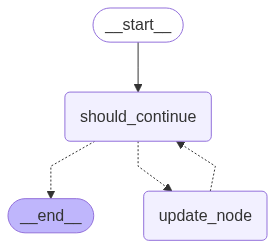

In [84]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [85]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Check your counter value, then update it twice, then check its value again, then update it two more times",
            }
        ],
        "remaining_steps" : 4,
        "counter" : 0 
    }
):
    print(chunk)

{'should_continue': {'messages': [AIMessage(content='Continue the workflow', additional_kwargs={}, response_metadata={}, id='abcd1ca5-ad7a-42a9-98ec-7d2d6a64847a')]}}
{'update_node': {'counter': 1, 'remaining_steps': -1, 'messages': [HumanMessage(content='Check your counter value, then update it twice, then check its value again, then update it two more times', additional_kwargs={}, response_metadata={}, id='6e2b3ae9-06f9-42d8-b03e-0ebb029a73cd'), AIMessage(content='Continue the workflow', additional_kwargs={}, response_metadata={}, id='abcd1ca5-ad7a-42a9-98ec-7d2d6a64847a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xHMAxZnQvdtDWuUxUIv76HIk', 'function': {'arguments': '{}', 'name': 'update_counter_new'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 80, 'total_tokens': 91, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_pr

It works. This is interesting not only for the recursion limit fixes, but also because it reminds us that we can actually build very structured and controlled graph flows, by constructing the graph ourselves. 